In [6]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv('train.zip', index_col=0, header=[0, 1])
dataset.rename(
    columns={
        'Unnamed: 209_level_1': 'count',
        'Unnamed: 210_level_1': 'price',
    },
    level = 1,
    inplace = True
)
dataset.head()

timestamp_second bid_price_0                                                \
                     nunique       mean   median       std     min     max   
0                          7  44.183379  44.1865  0.007340  44.171  44.190   
1                          1  44.190000  44.1900  0.000000  44.190  44.190   
2                          3  44.187467  44.1860  0.001767  44.186  44.190   
3                          3  44.181038  44.1860  0.006993  44.173  44.188   
4                          2  44.213095  44.2190  0.012474  44.188  44.219   

timestamp_second                 bid_quantity_0          ...  \
                   first    last            sum nunique  ...   
0                 44.171  44.190        25880.7       5  ...   
1                 44.190  44.190           76.7       1  ...   
2                 44.190  44.186          597.5       3  ...   
3                 44.186  44.188         2062.8       2  ...   
4                 44.188  44.219         6350.8       2  ...   

timestamp_second sell_trade_quantity                                    count  \
                             nunique mean median std min max first last count   
0                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    66   
1                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    13   
2                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    15   
3                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    52   
4                                  0  NaN    NaN NaN NaN NaN   NaN  NaN    21   

timestamp_second    price  
                    price  
0                 44.2005  
1                 44.2195  
2                 44.2195  
3                 44.2175  
4                 44.2060  

[5 rows x 210 columns]

In [29]:
class Dataloader():
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        window_size: int, 
        step_size: int,
        horizon: int,
        first_pred: int
    ):
        self.df = dataframe
        self.window_size = window_size
        self.step_size = step_size
        self.horizon = horizon
        self.first_pred = first_pred
        assert self.first_pred > self.window_size
        feat_idx = []
        target_idx = []
        for i in range(self.first_pred, self.df.shape[0], self.step_size):
            feat_idx.append(range(i-self.horizon-self.window_size+1, i-self.horizon+1))
            target_idx.append(i)
        self.feat_idx = feat_idx
        self.target_idx = target_idx
    
    def __len__(self):
        return len(self.feat_idx)
    
    def __iter__(self):
        self.iter = 0
        return self

    def __next__(self):
        if self.iter < len(self.feat_idx):
            feat = self.df.iloc[self.feat_idx[self.iter]]
            target = self.df.iloc[self.target_idx[self.iter], -1]
            self.iter += 1
            return feat, target
        else:
            raise StopIteration

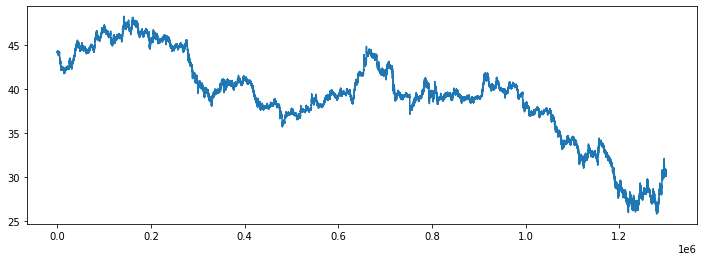

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(dataset['price']);

In [17]:
price_slices = dataset['price'][::60]

In [26]:
price_slices

,price
0,44.2005
60,44.1515
120,44.2200
180,44.1670
240,44.1775
...,...
1299720,30.5655
1299780,30.6625
1299840,30.7890
1299900,30.7880


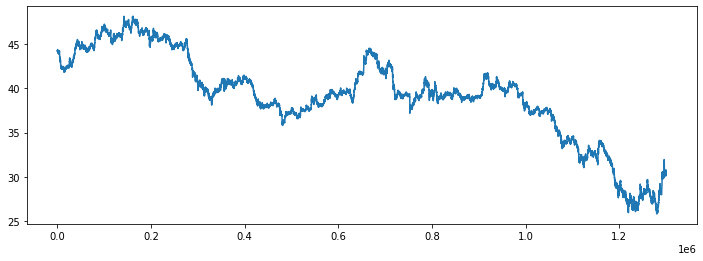

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(price_slices);

In [20]:
d_price_slices = (price_slices-price_slices.shift()).dropna()

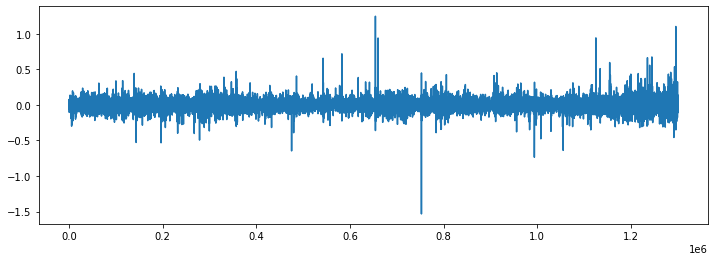

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(d_price_slices);

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(dataset['price'])

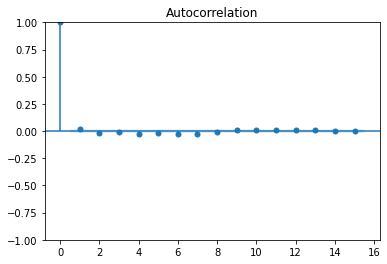

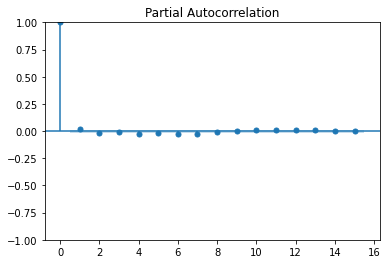

In [21]:
plot_acf(d_price_slices, lags = 15);
plot_pacf(d_price_slices, lags = 15, method = "ols");

In [22]:
fit = auto_arima(d_price_slices, trace=True, suppress_warnings=True)
fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-49597.718, Time=4.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-49593.229, Time=1.47 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-49598.260, Time=0.72 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-49598.482, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-49593.822, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-49599.520, Time=2.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-49627.783, Time=10.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-49601.654, Time=1.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-49598.608, Time=1.64 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-49619.423, Time=6.72 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-49600.682, Time=1.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-49596.816, Time=3.73 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-49628.062, Time=1.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-49600.155, Time=0.91 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                21666
Model:               SARIMAX(2, 0, 1)   Log Likelihood               24818.031
Date:                Sat, 12 Nov 2022   AIC                         -49628.062
Time:                        17:35:47   BIC                         -49596.128
Sample:                             0   HQIC                        -49617.655
                              - 21666                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8162      0.051     16.071      0.000       0.717       0.916
ar.L2         -0.0380      0.005     -7.581      0.000      -0.048      -0.028
ma.L1         -0.7989      0.051    -15.770      0.000      -0.898      -0.700
sigma2         0.0059   1.86e-05    318.154      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            333591.89
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have found optimal order for our ARIMA model - (2, 1, 1)

In [38]:
%%time
l = 10000
model=ARIMA(price_slices[:l],order=(2,1,1), trend = 't')
model = model.fit()

CPU times: user 2.04 s, sys: 1.23 s, total: 3.26 s
Wall time: 1.39 s


CPU times: user 3min 28s, sys: 4min 2s, total: 7min 31s
Wall time: 58.7 s


0.00667253706498946

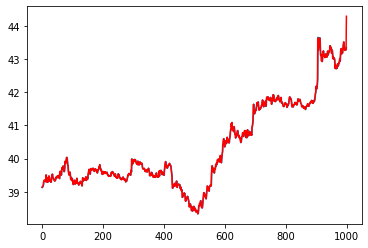

In [39]:
%%time
fit = []
target = []
for t in range(l,l+1000):
    model = model.append(endog = price_slices.values[t], refit = False)
    result=model.predict(t+1, t+1).values
    
    fit.append(result)
    target.append(price_slices.values[t+1])
    
    
plt.plot(fit)
plt.plot(target, color = 'r')
mse(fit, target)

Splitting the whole dataset into 60 slices and using 60 separate ARIMA models to predict price after 60 seconds horizon

In [30]:
window_size = 1000

In [60]:
loader = Dataloader(
    dataframe=dataset[:1500], 
    window_size=window_size, 
    step_size=1, 
    horizon=60, 
    first_pred=1060)

for feat, target in loader:
    break
feat.shape, target

((1000, 210), 44.0695)

In [61]:
class ForecastingModel():
    def __init__(self):
        self.models = None
        self.j = 0
        self.t = []
        
    def init2(self, prices):
        last_ind = prices.index[-1]
        self.models = []
        for j in range(0,60):
            self.t.append(len(prices[j::60])+1)
            model=ARIMA(prices[j::60].values,order=(2,1,1), trend = 't')
            self.models.append(model.fit())
            if prices[j::60].index[-1] == last_ind:
                self.j = j%60
            
    def forecast(self, feat):
        prices = feat['price']

        if not self.models:
            self.init2(prices)
            
            
        self.j = (self.j+1)%60   
        
        if np.isnan(prices.values[-1]):
            result=self.models[self.j].predict(self.t[self.j], self.t[self.j])
            self.models[self.j] = self.models[self.j].append(endog = result, refit = False)
            self.t[self.j]+=1
            return result
        
        self.models[self.j] = self.models[self.j].append(endog = prices.values[-1], refit = False)
            
        result=self.models[self.j].predict(self.t[self.j], self.t[self.j])
        self.t[self.j]+=1   
        
        return result

model = ForecastingModel()

In [62]:
def forecast(feat):
    
    return model.forecast(feat)

In [63]:
%%time
pred = []
target = []
for feat, _target in loader:
    pred.append(forecast(feat))
    target.append(_target)
mse(pred, target)

CPU times: user 3.28 s, sys: 79.5 ms, total: 3.36 s
Wall time: 3.27 s


0.0023399030532050523

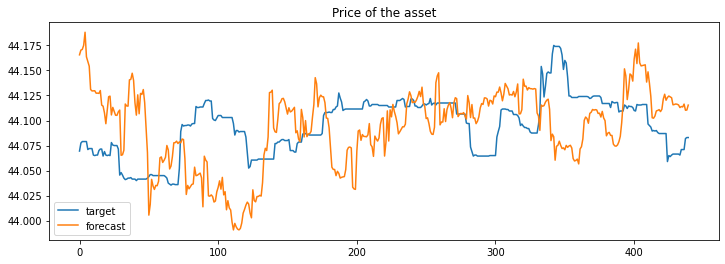

In [64]:
plt.figure(figsize=(12, 4))
plt.plot(target, label='target')
plt.plot(pred, label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()

More accurate solution would require refitting every time using refit = True, but that's too time consuming